In [11]:
import numpy as np 
import ast
import re

In [12]:
import pandas as pd
df = pd.read_csv("companies_2024.csv")

In [13]:
def parse_founded_date(date_str):
    try:
        date_dict = ast.literal_eval(date_str)
        return pd.to_datetime(date_dict["value"])
    except:
        return pd.NaT

df['founded_date'] = df['founded_on'].apply(parse_founded_date)
df['founded_precision'] = df['founded_on'].apply(
    lambda x: ast.literal_eval(x)['precision'] if pd.notna(x) else None
)

# Parse website URLs
df['website_url'] = df['website'].apply(
    lambda x: ast.literal_eval(x)['value'] if pd.notna(x) else None
)

# Parse employee ranges from codes
def parse_employee_range(code):
    if pd.isna(code) or code == '':
        return None, None
    # Extract numbers from codes like c_00011_00050
    numbers = re.findall(r'\d+', code)
    if len(numbers) >= 2:
        return int(numbers[0]), int(numbers[1])
    return None, None

df[['employees_min', 'employees_max']] = pd.DataFrame(
    df['num_employees_enum'].apply(parse_employee_range).tolist()
)
df['employees_midpoint'] = (df['employees_min'] + df['employees_max']) / 2

# Split categories into lists
df['categories_list'] = df['categories'].apply(
    lambda x: [cat.strip() for cat in str(x).split(';')] if pd.notna(x) and x != '' else []
)
df['category_count'] = df['categories_list'].apply(len)

print("Data loaded and parsed successfully!")
print(f"Total companies: {len(df)}")
print(f"Columns: {list(df.columns)}")

Data loaded and parsed successfully!
Total companies: 26012
Columns: ['uuid', 'name', 'permalink', 'founded_on', 'short_description', 'website', 'num_employees_enum', 'categories', 'founded_date', 'founded_precision', 'website_url', 'employees_min', 'employees_max', 'employees_midpoint', 'categories_list', 'category_count']


In [14]:
# Dataset Overview
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total companies: {len(df):,}")
print(f"Companies with valid dates: {df['founded_date'].notna().sum():,}")
print(f"Companies with employee data: {df['num_employees_enum'].notna().sum():,}")
print(f"Companies with categories: {df['categories'].notna().sum():,}")
print(f"Average categories per company: {df['category_count'].mean():.2f}")
print(f"Companies with websites: {df['website_url'].notna().sum():,}")
print("\nDate Precision Distribution:")
print(df['founded_precision'].value_counts())


DATASET OVERVIEW
Total companies: 26,012
Companies with valid dates: 26,012
Companies with employee data: 23,818
Companies with categories: 21,274
Average categories per company: 2.60
Companies with websites: 24,715

Date Precision Distribution:
founded_precision
day      12828
year      9990
month     3194
Name: count, dtype: int64


In [15]:
# Category Analysis - Most Common Categories
from collections import Counter

all_categories = []
for cats in df['categories_list']:
    all_categories.extend(cats)

category_counts = pd.Series(Counter(all_categories)).sort_values(ascending=False)

print("=" * 60)
print("TOP 20 MOST COMMON CATEGORIES")
print("=" * 60)
top_20 = category_counts.head(20)
for i, (cat, count) in enumerate(top_20.items(), 1):
    pct = (count / len(df)) * 100
    print(f"{i:2d}. {cat:50s} {count:5,} companies ({pct:5.2f}%)")

print(f"\nTotal unique categories: {len(category_counts):,}")


TOP 20 MOST COMMON CATEGORIES
 1. Software                                           5,171 companies (19.88%)
 2. Artificial Intelligence (AI)                       5,036 companies (19.36%)
 3. Information Technology                             3,114 companies (11.97%)
 4. SaaS                                               1,896 companies ( 7.29%)
 5. Consulting                                         1,383 companies ( 5.32%)
 6. Health Care                                        1,284 companies ( 4.94%)
 7. Financial Services                                 1,152 companies ( 4.43%)
 8. Generative AI                                      1,009 companies ( 3.88%)
 9. E-Commerce                                           980 companies ( 3.77%)
10. Manufacturing                                        896 companies ( 3.44%)
11. Marketing                                            877 companies ( 3.37%)
12. FinTech                                              814 companies ( 3.13%)
13. Digita

Matplotlib is building the font cache; this may take a moment.


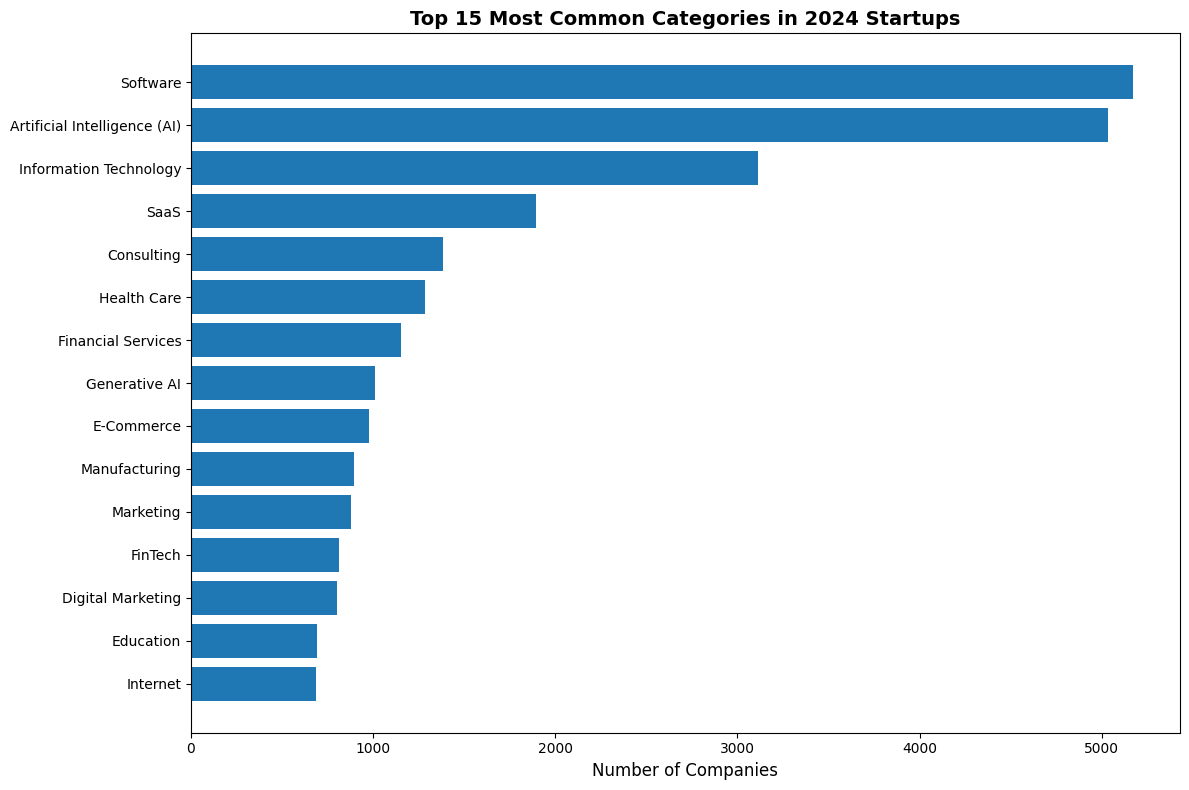

Top category 'Software' appears in 5,171 companies


In [16]:
# Visualize Top Categories
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_15 = category_counts.head(15)
plt.barh(range(len(top_15)), top_15.values)
plt.yticks(range(len(top_15)), top_15.index)
plt.xlabel('Number of Companies', fontsize=12)
plt.title('Top 15 Most Common Categories in 2024 Startups', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Top category '{category_counts.index[0]}' appears in {category_counts.iloc[0]:,} companies")


In [17]:
# Category Combinations Analysis
from itertools import combinations

category_pairs = []
for cats in df['categories_list']:
    if len(cats) >= 2:
        for pair in combinations(sorted(cats), 2):
            category_pairs.append(pair)

pair_counts = pd.Series(Counter(category_pairs)).sort_values(ascending=False)

print("=" * 60)
print("TOP 10 MOST COMMON CATEGORY PAIRS")
print("=" * 60)
for i, (pair, count) in enumerate(pair_counts.head(10).items(), 1):
    print(f"{i:2d}. {pair[0]:30s} + {pair[1]:30s} : {count:4,} companies")


TOP 10 MOST COMMON CATEGORY PAIRS
 1. Artificial Intelligence (AI)   + Software                       : 1,775 companies
 2. Information Technology         + Software                       : 1,426 companies
 3. Artificial Intelligence (AI)   + Information Technology         :  995 companies
 4. SaaS                           + Software                       :  779 companies
 5. Artificial Intelligence (AI)   + SaaS                           :  772 companies
 6. Artificial Intelligence (AI)   + Generative AI                  :  641 companies
 7. Artificial Intelligence (AI)   + Machine Learning               :  578 companies
 8. Consulting                     + Information Technology         :  390 companies
 9. Consulting                     + Software                       :  368 companies
10. Information Technology         + Internet                       :  349 companies


In [18]:
# Employee Size Analysis
print("=" * 60)
print("COMPANY SIZE DISTRIBUTION")
print("=" * 60)

employee_ranges = df['num_employees_enum'].value_counts().sort_index()
print("\nEmployee Range Distribution:")
for range_code, count in employee_ranges.items():
    mask = df['num_employees_enum'] == range_code
    if df[mask]['employees_min'].notna().any():
        min_emp = int(df[mask]['employees_min'].iloc[0])
        max_emp = int(df[mask]['employees_max'].iloc[0])
        print(f"  {range_code:15s} ({min_emp:5d}-{max_emp:5d} employees): {count:5,} companies")

print(f"\nStatistics:")
print(f"  Average company size (midpoint): {df['employees_midpoint'].mean():.0f} employees")
print(f"  Median company size: {df['employees_midpoint'].median():.0f} employees")
print(f"  Total estimated employees: {df['employees_midpoint'].sum():,.0f}")
print(f"  Smallest companies (1-10): {(df['employees_min'] <= 10).sum():,}")
print(f"  Medium companies (11-50): {((df['employees_min'] > 10) & (df['employees_max'] <= 50)).sum():,}")
print(f"  Large companies (51+): {(df['employees_min'] > 50).sum():,}")


COMPANY SIZE DISTRIBUTION

Employee Range Distribution:
  c_00001_00010   (    1-   10 employees): 17,780 companies
  c_00011_00050   (   11-   50 employees): 4,899 companies
  c_00051_00100   (   51-  100 employees):   659 companies
  c_00101_00250   (  101-  250 employees):   228 companies
  c_00251_00500   (  251-  500 employees):    80 companies
  c_00501_01000   (  501- 1000 employees):    71 companies
  c_01001_05000   ( 1001- 5000 employees):    59 companies
  c_05001_10000   ( 5001-10000 employees):    21 companies

Statistics:
  Average company size (midpoint): 32 employees
  Median company size: 6 employees
  Total estimated employees: 754,844
  Smallest companies (1-10): 17,780
  Medium companies (11-50): 4,899
  Large companies (51+): 1,118


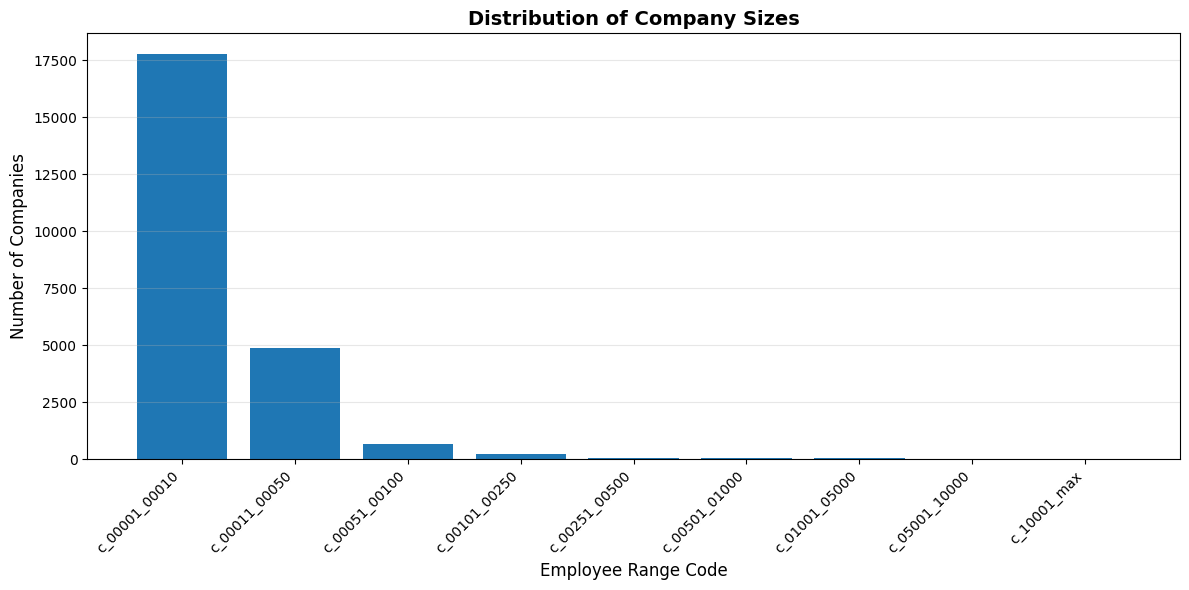

In [19]:
# Visualize Employee Size Distribution
plt.figure(figsize=(12, 6))
employee_ranges_sorted = df['num_employees_enum'].value_counts().sort_index()
plt.bar(range(len(employee_ranges_sorted)), employee_ranges_sorted.values)
plt.xticks(range(len(employee_ranges_sorted)), employee_ranges_sorted.index, rotation=45, ha='right')
plt.xlabel('Employee Range Code', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)
plt.title('Distribution of Company Sizes', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
# Sector-Specific Analysis
print("=" * 60)
print("SECTOR-SPECIFIC ANALYSIS")
print("=" * 60)

sectors = {
    'Artificial Intelligence (AI)': 'Artificial Intelligence',
    'Blockchain': 'Blockchain',
    'Cryptocurrency': 'Cryptocurrency',
    'Biotechnology': 'Biotechnology',
    'Robotics': 'Robotics',
    'CleanTech': 'CleanTech',
    'FinTech': 'FinTech',
    'Health Care': 'Health Care'
}

sector_stats = []
for sector_name, search_term in sectors.items():
    mask = df['categories'].str.contains(search_term, na=False, case=False)
    count = mask.sum()
    if count > 0:
        avg_size = df[mask]['employees_midpoint'].mean()
        median_size = df[mask]['employees_midpoint'].median()
        sector_stats.append({
            'Sector': sector_name,
            'Count': count,
            'Percentage': (count / len(df)) * 100,
            'Avg Employees': avg_size,
            'Median Employees': median_size
        })

sector_df = pd.DataFrame(sector_stats).sort_values('Count', ascending=False)
print(sector_df.to_string(index=False))


SECTOR-SPECIFIC ANALYSIS
                      Sector  Count  Percentage  Avg Employees  Median Employees
Artificial Intelligence (AI)   5036   19.360295      17.954259               5.5
                 Health Care   1302    5.005382      33.468750               5.5
                     FinTech    814    3.129325      22.255181               5.5
                  Blockchain    620    2.383515      20.234513               5.5
              Cryptocurrency    446    1.714593      20.869898               5.5
               Biotechnology    414    1.591573      14.236559               5.5
                    Robotics    234    0.899585      62.463351               5.5
                   CleanTech     82    0.315239      19.266234               5.5


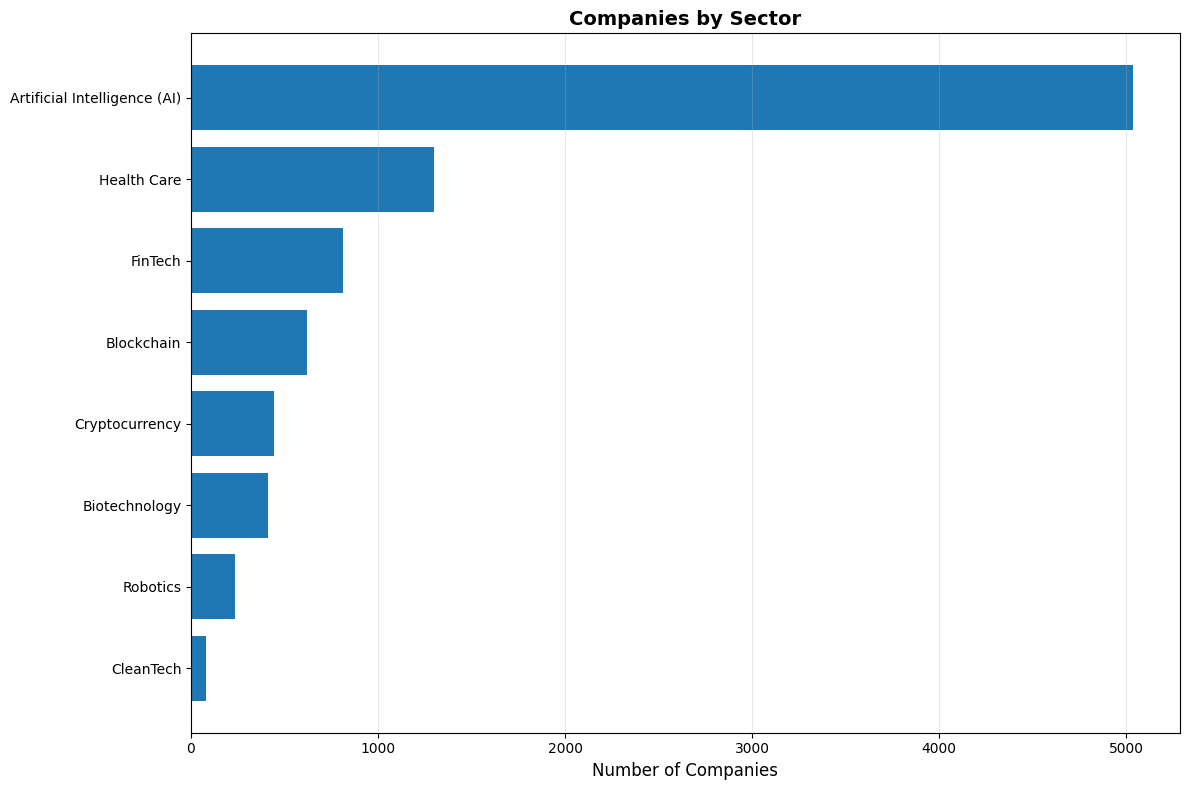

In [21]:
# Visualize Sector Distribution
plt.figure(figsize=(12, 8))
sector_df_sorted = sector_df.sort_values('Count', ascending=True)
plt.barh(range(len(sector_df_sorted)), sector_df_sorted['Count'].values)
plt.yticks(range(len(sector_df_sorted)), sector_df_sorted['Sector'].values)
plt.xlabel('Number of Companies', fontsize=12)
plt.title('Companies by Sector', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
# Temporal Analysis - Companies Founded by Month
print("=" * 60)
print("TEMPORAL ANALYSIS")
print("=" * 60)

df['founded_month'] = df['founded_date'].dt.month
df['founded_month_name'] = df['founded_date'].dt.strftime('%B')
df['founded_quarter'] = df['founded_date'].dt.quarter

monthly_foundings = df.groupby('founded_month')['name'].count()
monthly_foundings_named = df.groupby('founded_month_name')['name'].count()

print("\nCompanies Founded by Month:")
for month_num in sorted(monthly_foundings.index):
    month_name = pd.to_datetime(f'2024-{month_num}-01').strftime('%B')
    count = monthly_foundings[month_num]
    print(f"  {month_name:12s}: {count:5,} companies")

print("\nCompanies Founded by Quarter:")
quarterly_trend = df.groupby('founded_quarter')['name'].count()
for quarter, count in quarterly_trend.items():
    print(f"  Q{quarter}: {count:5,} companies")


TEMPORAL ANALYSIS

Companies Founded by Month:
  January     : 13,032 companies
  February    : 1,317 companies
  March       : 1,508 companies
  April       : 1,402 companies
  May         : 1,240 companies
  June        : 1,161 companies
  July        : 1,099 companies
  August      : 1,133 companies
  September   : 1,086 companies
  October     : 1,100 companies
  November    : 1,014 companies
  December    :   920 companies

Companies Founded by Quarter:
  Q1: 15,857 companies
  Q2: 3,803 companies
  Q3: 3,318 companies
  Q4: 3,034 companies


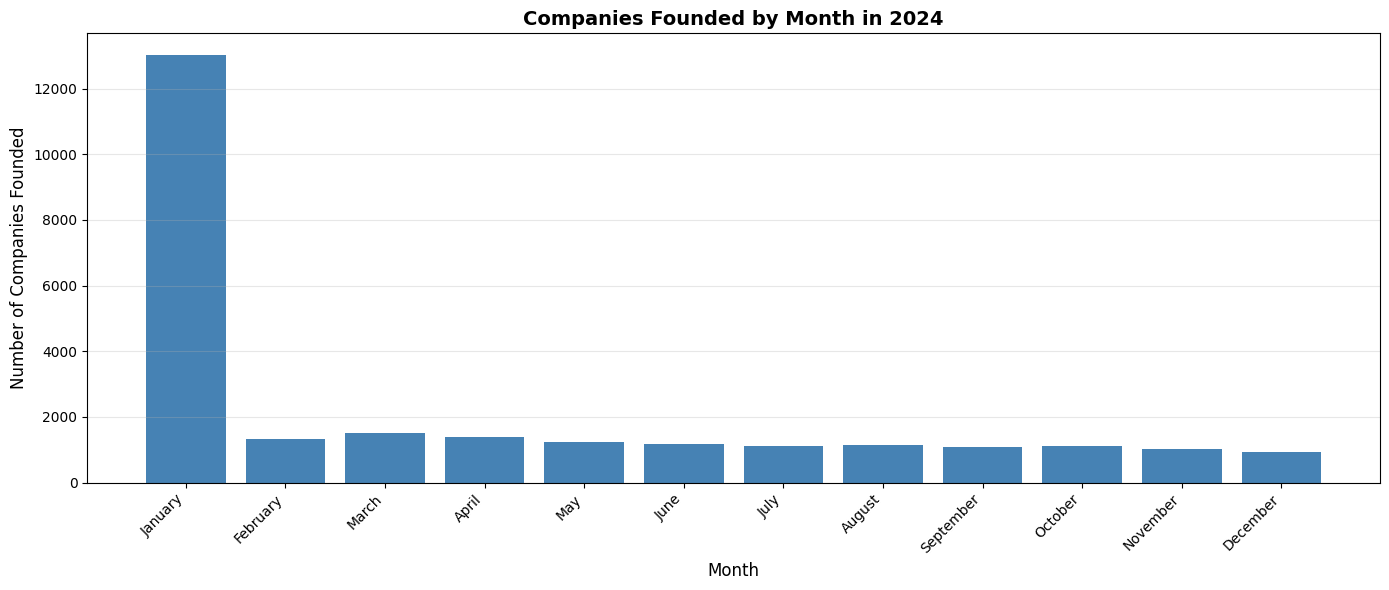

In [23]:
# Visualize Monthly Founding Trends
plt.figure(figsize=(14, 6))
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
monthly_ordered = df.groupby('founded_month_name')['name'].count().reindex(month_order, fill_value=0)

plt.bar(range(len(monthly_ordered)), monthly_ordered.values, color='steelblue')
plt.xticks(range(len(monthly_ordered)), monthly_ordered.index, rotation=45, ha='right')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Companies Founded', fontsize=12)
plt.title('Companies Founded by Month in 2024', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:
# Text Analysis on Descriptions
print("=" * 60)
print("DESCRIPTION ANALYSIS")
print("=" * 60)

df['description_length'] = df['short_description'].str.len()
df['description_word_count'] = df['short_description'].str.split().str.len()

print(f"\nDescription Statistics:")
print(f"  Average length: {df['description_length'].mean():.0f} characters")
print(f"  Median length: {df['description_length'].median():.0f} characters")
print(f"  Average word count: {df['description_word_count'].mean():.0f} words")
print(f"  Median word count: {df['description_word_count'].median():.0f} words")

# Most common words
from collections import Counter
import string

all_words = []
for desc in df['short_description'].dropna():
    words = desc.lower().translate(str.maketrans('', '', string.punctuation)).split()
    all_words.extend([w for w in words if len(w) > 3])  # Filter short words

word_counts = pd.Series(Counter(all_words)).sort_values(ascending=False)
print(f"\nTop 15 words in descriptions:")
for i, (word, count) in enumerate(word_counts.head(15).items(), 1):
    print(f"  {i:2d}. {word:20s}: {count:6,} occurrences")


DESCRIPTION ANALYSIS

Description Statistics:
  Average length: 90 characters
  Median length: 99 characters
  Average word count: 13 words
  Median word count: 14 words

Top 15 words in descriptions:
   1. that                :  5,207 occurrences
   2. platform            :  3,908 occurrences
   3. with                :  3,299 occurrences
   4. company             :  2,758 occurrences
   5. offers              :  2,423 occurrences
   6. services            :  2,300 occurrences
   7. provides            :  2,069 occurrences
   8. solutions           :  1,851 occurrences
   9. digital             :  1,689 occurrences
  10. your                :  1,499 occurrences
  11. management          :  1,350 occurrences
  12. software            :  1,316 occurrences
  13. saas                :  1,279 occurrences
  14. technology          :  1,268 occurrences
  15. marketing           :  1,232 occurrences


In [25]:
# AI Keyword Analysis
ai_keywords = ['ai', 'artificial intelligence', 'machine learning', 'deep learning', 
               'neural', 'algorithm', 'automation', 'intelligent', 'generative ai']
df['mentions_ai'] = df['short_description'].str.lower().str.contains('|'.join(ai_keywords), na=False)

ai_count = df['mentions_ai'].sum()
ai_pct = (ai_count / len(df)) * 100
print("=" * 60)
print("AI KEYWORD ANALYSIS")
print("=" * 60)
print(f"Companies mentioning AI in description: {ai_count:,} ({ai_pct:.1f}%)")
print(f"Companies with AI category: {(df['categories'].str.contains('Artificial Intelligence', na=False)).sum():,}")

# Companies in multiple high-growth sectors
high_growth_sectors = ['Artificial Intelligence', 'Blockchain', 'Cryptocurrency', 
                       'Biotechnology', 'Robotics', 'CleanTech']
df['high_growth_count'] = df['categories'].apply(
    lambda x: sum(1 for sector in high_growth_sectors if sector in str(x))
)

multi_sector = df[df['high_growth_count'] >= 2]
print(f"\nCompanies in multiple high-growth sectors (2+): {len(multi_sector):,}")
print(f"Companies in 3+ high-growth sectors: {(df['high_growth_count'] >= 3).sum():,}")


AI KEYWORD ANALYSIS
Companies mentioning AI in description: 9,852 (37.9%)
Companies with AI category: 5,036

Companies in multiple high-growth sectors (2+): 576
Companies in 3+ high-growth sectors: 40


In [26]:
# Category Diversity Analysis
print("=" * 60)
print("CATEGORY DIVERSITY ANALYSIS")
print("=" * 60)

print(f"Average categories per company: {df['category_count'].mean():.2f}")
print(f"Median categories per company: {df['category_count'].median():.0f}")
print(f"Most diverse company: {df.loc[df['category_count'].idxmax(), 'name']}")
print(f"  Categories: {df.loc[df['category_count'].idxmax(), 'category_count']}")
print(f"  Categories list: {', '.join(df.loc[df['category_count'].idxmax(), 'categories_list'][:10])}")

# Distribution of category counts
print(f"\nCategory Count Distribution:")
category_dist = df['category_count'].value_counts().sort_index()
for count, num_companies in category_dist.items():
    print(f"  {count} category(s): {num_companies:5,} companies")


CATEGORY DIVERSITY ANALYSIS
Average categories per company: 2.60
Median categories per company: 3
Most diverse company: Trio
  Categories: 10
  Categories list: Artificial Intelligence (AI), Asset Management, Cloud Security, Compliance, Education, Enterprise Software, Health Care, Information Technology, Mobile Devices, SaaS

Category Count Distribution:
  0 category(s): 4,738 companies
  1 category(s): 3,865 companies
  2 category(s): 3,297 companies
  3 category(s): 7,116 companies
  4 category(s): 3,421 companies
  5 category(s): 1,624 companies
  6 category(s):   828 companies
  7 category(s):   467 companies
  8 category(s):   281 companies
  9 category(s):   188 companies
  10 category(s):   187 companies


In [27]:
# Website Domain Analysis
df['domain'] = df['website_url'].apply(
    lambda x: x.split('//')[-1].split('/')[0] if pd.notna(x) else None
)

print("=" * 60)
print("WEBSITE ANALYSIS")
print("=" * 60)
print(f"Unique domains: {df['domain'].nunique():,}")
print(f"Companies with websites: {df['website_url'].notna().sum():,}")

# Most common domain extensions
df['domain_ext'] = df['domain'].apply(
    lambda x: x.split('.')[-1] if pd.notna(x) else None
)
ext_counts = df['domain_ext'].value_counts().head(10)
print(f"\nTop 10 Domain Extensions:")
for ext, count in ext_counts.items():
    print(f"  .{ext:5s}: {count:5,} companies")


WEBSITE ANALYSIS
Unique domains: 24,583
Companies with websites: 24,715

Top 10 Domain Extensions:
  .com  : 12,880 companies
  .ai   : 2,945 companies
  .io   : 1,186 companies
  .co   :   773 companies
  .in   :   492 companies
  .org  :   473 companies
  .app  :   407 companies
  .uk   :   336 companies
  .net  :   326 companies
  .tech :   222 companies


In [28]:
# Key Insights Summary
print("=" * 60)
print("KEY INSIGHTS SUMMARY")
print("=" * 60)

insights = [
    f"1. Total companies analyzed: {len(df):,}",
    f"2. Most common category: '{category_counts.index[0]}' ({category_counts.iloc[0]:,} companies)",
    f"3. AI companies: {(df['categories'].str.contains('Artificial Intelligence', na=False)).sum():,} ({(df['categories'].str.contains('Artificial Intelligence', na=False)).sum()/len(df)*100:.1f}%)",
    f"4. Average company size: {df['employees_midpoint'].mean():.0f} employees",
    f"5. Smallest companies (1-10 employees): {(df['employees_min'] <= 10).sum():,}",
    f"6. Average categories per company: {df['category_count'].mean():.2f}",
    f"7. Most diverse company has {df['category_count'].max()} categories",
    f"8. Peak founding month: {monthly_ordered.idxmax()} ({monthly_ordered.max():,} companies)",
    f"9. Companies in multiple high-growth sectors: {len(multi_sector):,}",
    f"10. Unique categories in dataset: {len(category_counts):,}"
]

for insight in insights:
    print(insight)


KEY INSIGHTS SUMMARY
1. Total companies analyzed: 26,012
2. Most common category: 'Software' (5,171 companies)
3. AI companies: 5,036 (19.4%)
4. Average company size: 32 employees
5. Smallest companies (1-10 employees): 17,780
6. Average categories per company: 2.60
7. Most diverse company has 10 categories
8. Peak founding month: January (13,032 companies)
9. Companies in multiple high-growth sectors: 576
10. Unique categories in dataset: 765


In [29]:
# Export Summary Statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Companies',
        'AI Companies',
        'Blockchain Companies',
        'Cryptocurrency Companies',
        'Biotech Companies',
        'Robotics Companies',
        'Average Employees',
        'Median Employees',
        'Most Common Category',
        'Average Categories per Company',
        'Companies with 50+ employees',
        'Unique Categories',
        'Companies with Websites'
    ],
    'Value': [
        len(df),
        (df['categories'].str.contains('Artificial Intelligence', na=False)).sum(),
        (df['categories'].str.contains('Blockchain', na=False)).sum(),
        (df['categories'].str.contains('Cryptocurrency', na=False)).sum(),
        (df['categories'].str.contains('Biotechnology', na=False)).sum(),
        (df['categories'].str.contains('Robotics', na=False)).sum(),
        f"{df['employees_midpoint'].mean():.0f}",
        f"{df['employees_midpoint'].median():.0f}",
        category_counts.index[0],
        f"{df['category_count'].mean():.2f}",
        (df['employees_min'] >= 50).sum(),
        len(category_counts),
        df['website_url'].notna().sum()
    ]
})

summary_stats.to_csv('analysis_summary.csv', index=False)
print("Summary statistics exported to 'analysis_summary.csv'")
print("\nFirst few rows:")
print(summary_stats.head(10).to_string(index=False))


Summary statistics exported to 'analysis_summary.csv'

First few rows:
                        Metric    Value
               Total Companies    26012
                  AI Companies     5036
          Blockchain Companies      620
      Cryptocurrency Companies      446
             Biotech Companies      414
            Robotics Companies      234
             Average Employees       32
              Median Employees        6
          Most Common Category Software
Average Categories per Company     2.60


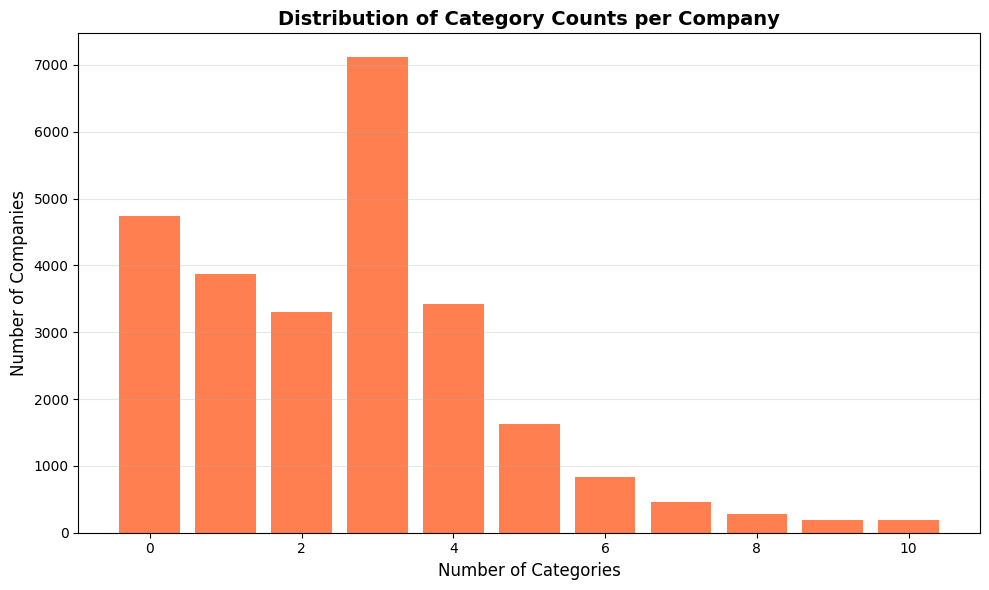

Most companies have 3 category/categories


In [30]:
# Additional Visualizations: Category Count Distribution
plt.figure(figsize=(10, 6))
category_dist = df['category_count'].value_counts().sort_index()
plt.bar(category_dist.index, category_dist.values, color='coral')
plt.xlabel('Number of Categories', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)
plt.title('Distribution of Category Counts per Company', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Most companies have {category_dist.idxmax()} category/categories")


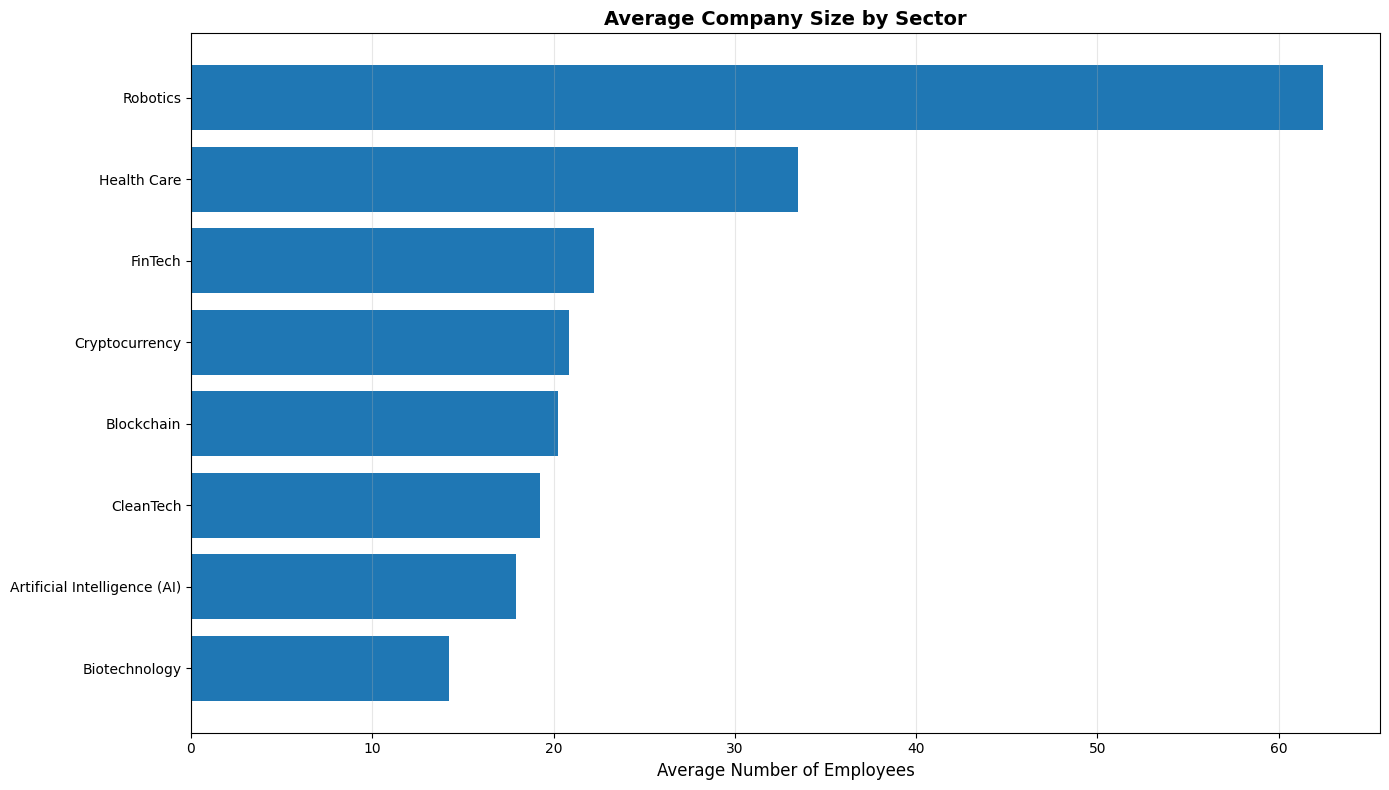

In [31]:
# Sector Size Comparison
plt.figure(figsize=(14, 8))
sector_size_data = []
for sector_name, search_term in sectors.items():
    mask = df['categories'].str.contains(search_term, na=False, case=False)
    if mask.sum() > 0:
        avg_size = df[mask]['employees_midpoint'].mean()
        sector_size_data.append({'Sector': sector_name, 'Avg Employees': avg_size, 'Count': mask.sum()})

sector_size_df = pd.DataFrame(sector_size_data).sort_values('Avg Employees', ascending=True)

plt.barh(range(len(sector_size_df)), sector_size_df['Avg Employees'].values)
plt.yticks(range(len(sector_size_df)), sector_size_df['Sector'].values)
plt.xlabel('Average Number of Employees', fontsize=12)
plt.title('Average Company Size by Sector', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [32]:
# Create Comprehensive AI Statistics CSV
print("=" * 60)
print("GENERATING AI STATISTICS CSV")
print("=" * 60)

# Ensure AI-related columns exist
if 'mentions_ai' not in df.columns:
    ai_keywords = ['ai', 'artificial intelligence', 'machine learning', 'deep learning', 
                   'neural', 'algorithm', 'automation', 'intelligent', 'generative ai']
    df['mentions_ai'] = df['short_description'].str.lower().str.contains('|'.join(ai_keywords), na=False)

# Create AI company mask
ai_category_mask = df['categories'].str.contains('Artificial Intelligence', na=False)
ai_description_mask = df['mentions_ai']
ai_combined_mask = ai_category_mask | ai_description_mask

# Overall AI Statistics
ai_stats = []

# 1. Overall AI Company Counts
ai_stats.append({
    'Metric_Category': 'Overall Counts',
    'Metric': 'Total Companies in Dataset',
    'Value': len(df),
    'Percentage': 100.0
})

ai_stats.append({
    'Metric_Category': 'Overall Counts',
    'Metric': 'Companies with AI Category',
    'Value': ai_category_mask.sum(),
    'Percentage': (ai_category_mask.sum() / len(df)) * 100
})

ai_stats.append({
    'Metric_Category': 'Overall Counts',
    'Metric': 'Companies Mentioning AI in Description',
    'Value': ai_description_mask.sum(),
    'Percentage': (ai_description_mask.sum() / len(df)) * 100
})

ai_stats.append({
    'Metric_Category': 'Overall Counts',
    'Metric': 'Companies with AI Category OR Mention',
    'Value': ai_combined_mask.sum(),
    'Percentage': (ai_combined_mask.sum() / len(df)) * 100
})

ai_stats.append({
    'Metric_Category': 'Overall Counts',
    'Metric': 'Companies with AI Category AND Mention',
    'Value': (ai_category_mask & ai_description_mask).sum(),
    'Percentage': ((ai_category_mask & ai_description_mask).sum() / len(df)) * 100
})

# 2. AI Company Size Statistics
ai_companies = df[ai_combined_mask]
if ai_companies['employees_midpoint'].notna().any():
    ai_stats.append({
        'Metric_Category': 'Company Size',
        'Metric': 'Average Employees (AI Companies)',
        'Value': ai_companies['employees_midpoint'].mean(),
        'Percentage': None
    })
    
    ai_stats.append({
        'Metric_Category': 'Company Size',
        'Metric': 'Median Employees (AI Companies)',
        'Value': ai_companies['employees_midpoint'].median(),
        'Percentage': None
    })
    
    ai_stats.append({
        'Metric_Category': 'Company Size',
        'Metric': 'Total Estimated Employees (AI Companies)',
        'Value': ai_companies['employees_midpoint'].sum(),
        'Percentage': None
    })
    
    ai_stats.append({
        'Metric_Category': 'Company Size',
        'Metric': 'Small AI Companies (1-10 employees)',
        'Value': (ai_companies['employees_min'] <= 10).sum(),
        'Percentage': ((ai_companies['employees_min'] <= 10).sum() / len(ai_companies)) * 100
    })
    
    ai_stats.append({
        'Metric_Category': 'Company Size',
        'Metric': 'Medium AI Companies (11-50 employees)',
        'Value': ((ai_companies['employees_min'] > 10) & (ai_companies['employees_max'] <= 50)).sum(),
        'Percentage': (((ai_companies['employees_min'] > 10) & (ai_companies['employees_max'] <= 50)).sum() / len(ai_companies)) * 100
    })
    
    ai_stats.append({
        'Metric_Category': 'Company Size',
        'Metric': 'Large AI Companies (51+ employees)',
        'Value': (ai_companies['employees_min'] > 50).sum(),
        'Percentage': ((ai_companies['employees_min'] > 50).sum() / len(ai_companies)) * 100
    })

# 3. AI Category Combinations
ai_categories = ['Artificial Intelligence (AI)', 'Machine Learning', 'Deep Learning', 
                 'Generative AI', 'Natural Language Processing', 'Computer Vision']
for cat in ai_categories:
    mask = df['categories'].str.contains(cat, na=False, case=False)
    if mask.sum() > 0:
        ai_stats.append({
            'Metric_Category': 'AI Subcategories',
            'Metric': f'Companies in {cat}',
            'Value': mask.sum(),
            'Percentage': (mask.sum() / len(df)) * 100
        })

# 4. AI + Other Sectors
other_sectors = ['Blockchain', 'Cryptocurrency', 'Biotechnology', 'Robotics', 
                 'Health Care', 'FinTech', 'E-Commerce', 'SaaS']
for sector in other_sectors:
    mask = ai_combined_mask & df['categories'].str.contains(sector, na=False, case=False)
    if mask.sum() > 0:
        ai_stats.append({
            'Metric_Category': 'AI + Other Sectors',
            'Metric': f'AI + {sector}',
            'Value': mask.sum(),
            'Percentage': (mask.sum() / len(df)) * 100
        })

# 5. Temporal Analysis for AI Companies
if ai_companies['founded_month'].notna().any():
    ai_monthly = ai_companies.groupby('founded_month_name')['name'].count()
    peak_month = ai_monthly.idxmax()
    ai_stats.append({
        'Metric_Category': 'Temporal',
        'Metric': 'Peak Founding Month (AI Companies)',
        'Value': ai_monthly.max(),
        'Percentage': None
    })
    
    ai_stats.append({
        'Metric_Category': 'Temporal',
        'Metric': 'Peak Month Name',
        'Value': peak_month,
        'Percentage': None
    })

# 6. Description Analysis for AI Companies
if ai_companies['description_length'].notna().any():
    ai_stats.append({
        'Metric_Category': 'Description',
        'Metric': 'Average Description Length (AI Companies)',
        'Value': ai_companies['description_length'].mean(),
        'Percentage': None
    })
    
    ai_stats.append({
        'Metric_Category': 'Description',
        'Metric': 'Average Word Count (AI Companies)',
        'Value': ai_companies['description_word_count'].mean(),
        'Percentage': None
    })

# 7. Category Diversity for AI Companies
if ai_companies['category_count'].notna().any():
    ai_stats.append({
        'Metric_Category': 'Category Diversity',
        'Metric': 'Average Categories per AI Company',
        'Value': ai_companies['category_count'].mean(),
        'Percentage': None
    })
    
    ai_stats.append({
        'Metric_Category': 'Category Diversity',
        'Metric': 'Most Diverse AI Company Categories',
        'Value': ai_companies['category_count'].max(),
        'Percentage': None
    })

# 8. Website Analysis
ai_stats.append({
    'Metric_Category': 'Web Presence',
    'Metric': 'AI Companies with Websites',
    'Value': ai_companies['website_url'].notna().sum(),
    'Percentage': (ai_companies['website_url'].notna().sum() / len(ai_companies)) * 100
})

# Create DataFrame and export
ai_stats_df = pd.DataFrame(ai_stats)
ai_stats_df.to_csv('ai_statistics.csv', index=False)

print(f"\nAI Statistics CSV created with {len(ai_stats_df)} metrics!")
print("\nFirst 15 rows:")
print(ai_stats_df.head(15).to_string(index=False))
print(f"\nFile saved as: ai_statistics.csv")


GENERATING AI STATISTICS CSV

AI Statistics CSV created with 30 metrics!

First 15 rows:
 Metric_Category                                   Metric      Value  Percentage
  Overall Counts               Total Companies in Dataset      26012  100.000000
  Overall Counts               Companies with AI Category       5036   19.360295
  Overall Counts   Companies Mentioning AI in Description       9852   37.874827
  Overall Counts    Companies with AI Category OR Mention      10872   41.796094
  Overall Counts   Companies with AI Category AND Mention       4016   15.439028
    Company Size         Average Employees (AI Companies)  25.110621         NaN
    Company Size          Median Employees (AI Companies)        5.5         NaN
    Company Size Total Estimated Employees (AI Companies)   253441.5         NaN
    Company Size      Small AI Companies (1-10 employees)       7613   70.023915
    Company Size    Medium AI Companies (11-50 employees)       2116   19.462840
    Company Size    

/var/folders/hh/ydg79r4d2357snpp2xyjqlc00000gn/T/ipykernel_80685/3493973139.py:105: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df['categories'].str.contains(cat, na=False, case=False)
